# **Test Best Model Performance with New Dataset: ruangguru's Clash of Champions Episodes 4**

## **1. Import Library**

In [11]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import csv
import requests
import unicodedata
import json
import os
import joblib

from io import StringIO, BytesIO

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import (
    Embedding,
    Dense,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling1D,
    GlobalMaxPooling1D,
    Conv1D,
    MaxPooling1D,
    SpatialDropout1D
)
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [36]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=1a9529c974a50dcd7033dc9097ac7a50ebfa4071af7844f95741ba133f5ae375
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [37]:
import wget

In [12]:
!pip install youtube-comment-downloader

In [13]:
from youtube_comment_downloader import *

In [14]:
downloader = YoutubeCommentDownloader()

In [15]:
!pip install --upgrade git+https://github.com/ariaghora/mpstemmer.git

  Cloning https://github.com/ariaghora/mpstemmer.git to /tmp/pip-req-build-2nvv9yt5
  Running command git clone --filter=blob:none --quiet https://github.com/ariaghora/mpstemmer.git /tmp/pip-req-build-2nvv9yt5
  Resolved https://github.com/ariaghora/mpstemmer.git to commit 25a5fd923af163a7eac3a5ec976984156ca8fa8b
  Preparing metadata (setup.py) ... done


In [16]:
!pip install Levenshtein

In [17]:
from mpstemmer import MPStemmer

stemmer = MPStemmer()

In [18]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [19]:
stopwords = set(stopwords.words('indonesian'))

In [20]:
!pip install emoji

In [21]:
import emoji

## **2. Scrape Dataset for Testing**

In [7]:
comments = downloader.get_comments_from_url("https://www.youtube.com/watch?v=_2yf29Wdekc")

comments_list = []

for comment in comments:
  comments_list.append(comment['text'])

In [8]:
import csv

# Save to CSV
with open('ruangguru_eps4.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['comment'])
    for comment in comments_list:
        writer.writerow([comment])

## **3. Load Dataset**

In [24]:
import pandas as pd

corpus = pd.read_csv('ruangguru_eps4.csv')
corpus

,comment
0,Tunggu episode 5 di Aplikasi dan Youtube Ruangguru pekan depan! Download aplikasi Ruangguru untuk coba soal dan gamesnya 🔥🔥[ https://s.id/cocapp ]
1,"Walaupun lulusan SMP tapi Saya ingin Belajar kaya gini, lomba lomba kaya gini bikin saya semngat.\n\n\n\nApalagi matematika wow hobi banget"
2,Semoga tahun depan ada yang bagian SMP sih seru kayaknya😹👍
3,https://youtube.com/playlist?list=PLDpk-iH-Gr78gzWEq8Xlz5gezNYJuDu4h&si=e7LDc9tkAdOxYHJa\n\n\nCOC Animasi
4,"team kenji vs tim shakira gg sih seru banget, either team yang kalah ataupun menang keren-keren semua"
...,...
11509,Sangat ku tunggu😫
11510,❤❤❤
11511,🔥🔥🔥
11512,aaaa❤


## **4. Dataset Preprocessing**

In [25]:
# Load normalized terms
normalized_term = {}

url = 'https://github.com/teguhary/Automated-labelling-Inset-Lexicon/raw/master/Data/kamus_kata_alay.xlsx'
response = requests.get(url)

if response.status_code == 200:
    df = pd.read_excel(BytesIO(response.content))
    normalized_term = dict(zip(df[df.columns[0]], df[df.columns[1]]))

else:
    print('Failed to fetch normalized words data')

In [26]:
# Function for corpus cleaning
def clean_corpus_docs(doc):
    # Remove emojis
    doc = emoji.replace_emoji(doc, replace='')

    # Normalize Unicode characters (e.g., combining characters)
    doc = unicodedata.normalize('NFKD', doc)

    # Lowercase the doc
    doc = doc.lower()

    # Remove mentions, hashtags, RTs, URLs, numbers, and punctuation
    doc = re.sub(r'(@[A-Za-z0-9]+|#[A-Za-z0-9]+|RT[\s]|http\S+|\d+|[^\w\s])', '', doc)

    # Remove extra whitespace and leading/trailing spaces
    doc = re.sub(r'\s+', ' ', doc).strip()

    # Reduce repeated characters (e.g., "sukaaa" to "suka", but keep "tuannya" as "tuannya", not "tuanya")
    doc = re.sub(r'(.)\1{2,}', r'\1', doc)

    # Tokenize the doc
    tokens = word_tokenize(doc)

    # Normalize and stem tokens
    tokens = [normalized_term.get(token, token) for token in tokens]  # Normalize
    tokens = [stemmer.stem(token) for token in tokens]              # Stem

    # Remove stopwords
    tokens = [token for token in tokens if token not in stopwords]

    # Remove token with characters <= 2
    tokens = [token for token in tokens if len(token) > 2]

    return tokens  # Return list of processed terms

In [27]:
# Clean the corpus
corpus['tokens'] = corpus['comment'].apply(clean_corpus_docs)

## **5. Dataset Labeling**

In [31]:
# Read positive term dictionary data from GitHub
lexicon_positive = dict()

# Send an HTTP request to get a CSV file from GitHub
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response.status_code == 200:
    # If the request succeeds
    # Read response text as a CSV file using a CSV reader with comma separators
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        # Loop through each row in a CSV file
        # Added positive term and their scores to the lexicon_positive dictionary
        lexicon_positive[row[0]] = int(row[1])

else:
    print('Failed to fetch positive lexicon date')

# Read negative term dictionary data from GitHub
lexicon_negative = dict()

# Send an HTTP request to get a CSV file from GitHub
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
    # If the request succeeds
    # Read response text as a CSV file using a CSV reader with comma separators
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        # Loop through each row in a CSV file
        # Added negative term and their scores to the lexicon_negative dictionary
        lexicon_negative[row[0]] = int(row[1])

else:
    print('Failed to fetch negative lexicon date')

In [32]:
# Function to determine the sentiment polarity of comments
def sentiment_analysis_lexicon_indonesia(doc):
    # For term in doc:
    score = 0 # Initialize sentiment score to 0
    for term in doc:
        # Loops every term in the doc
        if (term in lexicon_positive):
            # If the term is in the positive dictionary, add its score to the sentiment score
            score = score + lexicon_positive[term]

    for term in doc:
        # Loops every term in the doc again
        if (term in lexicon_negative):
            # If the term is in the negative dictionary, subtract its score to the sentiment score
            score = score + lexicon_negative[term]

    # Initialize polarity variables
    polarity = ''

    if score > 0:
        # If the sentiment score is greater than or equal to 0, then the polarity is positive
        polarity = 'positive'
    elif score < 0:
        # If the sentiment score is less than 0, then the polarity is negative
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [33]:
# Show the total number for each polarity
results = corpus['tokens'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
corpus['polarity_score'] = results[0]
corpus['polarity'] = results[1]
print(corpus['polarity'].value_counts())

polarity
negative    5006
neutral     3338
positive    3170
Name: count, dtype: int64


In [34]:
# Encode polarity to numerical label
le = LabelEncoder()
corpus['label'] = le.fit_transform(corpus['polarity'])
corpus

,comment,tokens,polarity_score,polarity,label
0,Tunggu episode 5 di Aplikasi dan Youtube Ruangguru pekan depan! Download aplikasi Ruangguru untuk coba soal dan gamesnya 🔥🔥[ https://s.id/cocapp ],"[tunggu, episode, aplikasi, youtube, ruangguru, pekan, download, aplikasi, ruangguru, coba, gamesnya]",-8,negative,0
1,"Walaupun lulusan SMP tapi Saya ingin Belajar kaya gini, lomba lomba kaya gini bikin saya semngat.\n\n\n\nApalagi matematika wow hobi banget","[lulus, ajar, kayak, lomba, lomba, kayak, bikin, semangat, matematika, wow, hobi, banget]",1,positive,2
2,Semoga tahun depan ada yang bagian SMP sih seru kayaknya😹👍,"[moga, sih, seru, kayak]",-2,negative,0
3,https://youtube.com/playlist?list=PLDpk-iH-Gr78gzWEq8Xlz5gezNYJuDu4h&si=e7LDc9tkAdOxYHJa\n\n\nCOC Animasi,"[coc, animasi]",0,neutral,1
4,"team kenji vs tim shakira gg sih seru banget, either team yang kalah ataupun menang keren-keren semua","[team, kenji, tim, shakira, sih, seru, banget, either, team, kalah, menang, kerenkeren]",-6,negative,0
...,...,...,...,...,...
11509,Sangat ku tunggu😫,[tunggu],-1,negative,0
11510,❤❤❤,[],0,neutral,1
11511,🔥🔥🔥,[],0,neutral,1
11512,aaaa❤,[],0,neutral,1


## **6. Model Testing**

### **Load Tokenizer**

In [44]:
url = 'https://github.com/kevinadityaikhsan/ruangguru-sentiment-analysis-classification/raw/main/model/tokenizer.pkl'
filename = wget.download(url)

In [45]:
tokenizer = joblib.load('tokenizer.pkl')

### **Load Model**

In [38]:
url = 'https://github.com/kevinadityaikhsan/ruangguru-sentiment-analysis-classification/raw/main/model/WE_3C_GAPLBN.keras'
filename = wget.download(url)

In [46]:
WE_3C_GAPLBN = tf.keras.models.load_model('WE_3C_GAPLBN.keras')

### **Test Model**

360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Accuracy: 0.93581726593712
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      5006
           1       0.92      0.91      0.91      3338
           2       0.93      0.94      0.94      3170

    accuracy                           0.94     11514
   macro avg       0.93      0.93      0.93     11514
weighted avg       0.94      0.94      0.94     11514



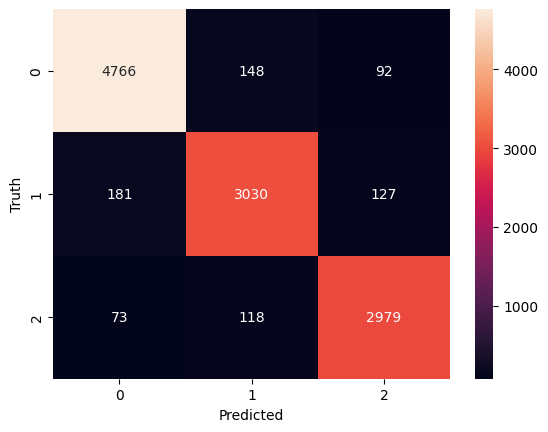

In [47]:
# Preprocess the new dataset
test_sequences = tokenizer.texts_to_sequences(corpus['tokens'])
test_padded = pad_sequences(test_sequences, maxlen=128)

# Make predictions
predictions = WE_3C_GAPLBN.predict(test_padded)
predicted_labels = np.argmax(predictions, axis=1)

# Decode predicted labels
predicted_polarities = le.inverse_transform(predicted_labels)

# Add predicted polarities to the corpus
corpus['predicted_polarity'] = predicted_polarities

# Evaluate the model
accuracy = accuracy_score(corpus['label'], predicted_labels)
print("Accuracy:", accuracy)

print(classification_report(corpus['label'], predicted_labels))

cm = confusion_matrix(corpus['label'], predicted_labels)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


## **7. Conclusion**

That's a wrap! Our sentiment analysis and text classification model, trained on episodes 1-3, maintained a remarkable 93.6% accuracy, even when tested on the unseen episode 4.  This demonstrates the model's effectiveness and potential for real-world applications.  Feel free to dive into the code and experiment further!